### Импорт библиотек

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, auc, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Загрузка данных

In [4]:
df = pd.read_csv('Loan_Approval_Prediction.csv')

Краткое описание каждого столбца в наборе данных:

* person_age: возраст клиента
* person_income: сколько денег зарабатывает клиент в год
* person_home_ownership: владеет ли клиент домом
* person_emp_length: стаж клиента
* loan_intent: причина кредита
* loan_grade: кредитный рейтинг клиента
* loan_amnt: сумма кредита
* loan_int_rate: процентная ставка кредита
* loan_percent_income: какой процент от дохода клиента пойдет на выплаты по кредиту
* cb_person_default_on_file: показывает, были ли у клиента просрочки по другим кредитам
* cb_person_cred_hist_length: как долго у клиента была кредитная история
* loan_status: показывает, был ли кредит одобрен.

In [10]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


### EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

Пропусков в данных нет

In [6]:
# Столбец id для нас неинформативен, поэтому сразу удалим его
df = df.drop(columns=['id'])

In [7]:
# Рассмотрим ключевые статистические показатели числовых метрик
df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate']].describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000


Возраст 123 года выглядит, как ошибка в данных. Удалим клиентов старше 100 лет.

In [8]:
df = df[df['person_age'] < 100]

### Построим некоторые графики, чтобы лучше понимать данные

#### Распределение числовых признаков

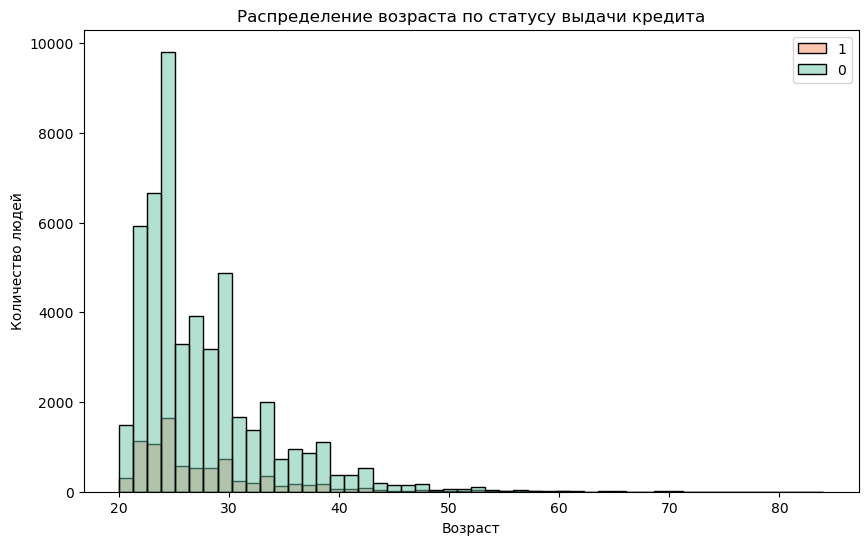

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='person_age', hue='loan_status', bins=50, palette='Set2', edgecolor='black', linewidth=1, multiple="layer")
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Распределение возраста по статусу выдачи кредита')
plt.legend(labels=['1', '0'])
plt.show()

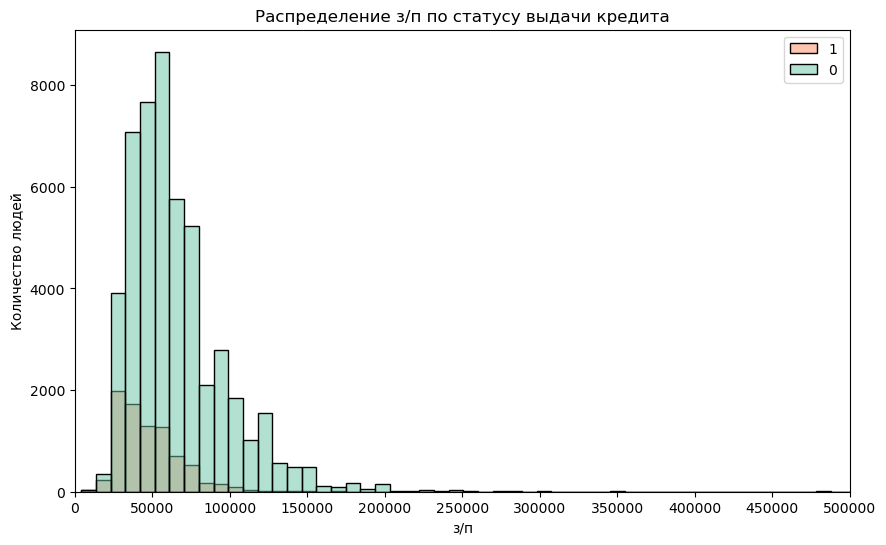

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='person_income', hue='loan_status', bins=200, palette='Set2', edgecolor='black', linewidth=1, multiple="layer")
plt.xlabel('з/п')
plt.ylabel('Количество людей')
plt.title('Распределение з/п по статусу выдачи кредита')
plt.xlim([0, 500000])
max_value = df['loan_amnt'].max()
min_value = df['loan_amnt'].min()
plt.xticks(np.arange(0, 500000 + 1, step=50000))
plt.legend(labels=['1', '0'])
plt.show()

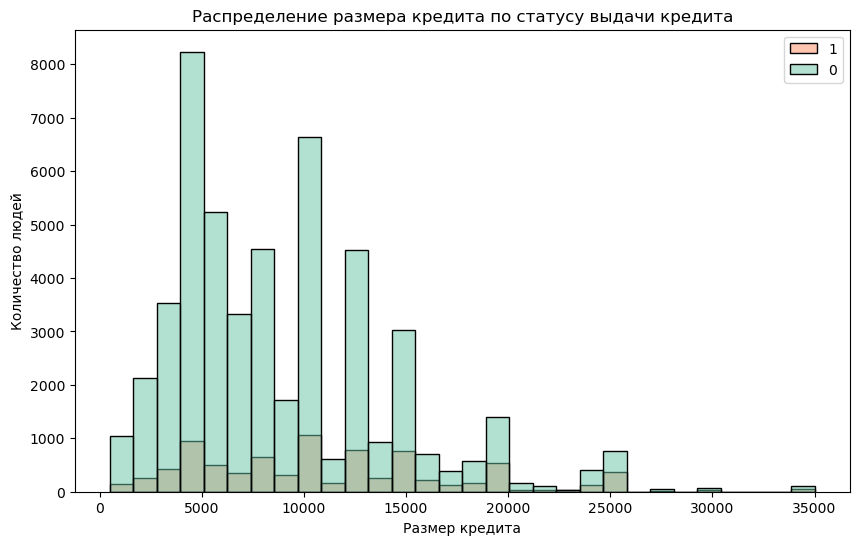

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='loan_amnt', hue='loan_status', bins=30, palette='Set2', edgecolor='black', linewidth=1, multiple="layer")
plt.xlabel('Размер кредита')
plt.ylabel('Количество людей')
plt.title('Распределение размера кредита по статусу выдачи кредита')
plt.legend(labels=['1', '0'])
plt.show()

#### Распределение категориальных признаков

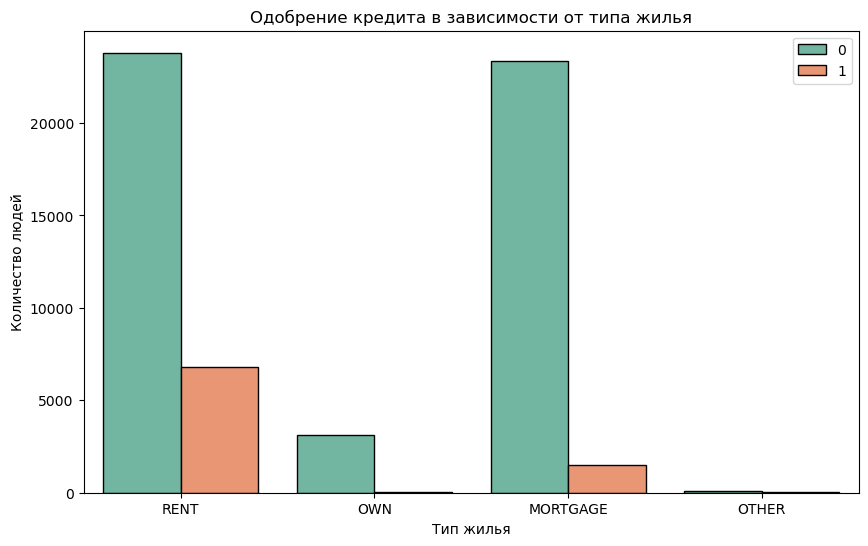

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', data=df, palette='Set2', hue='loan_status', edgecolor='black')
plt.xlabel('Тип жилья')
plt.ylabel('Количество людей')
plt.title('Одобрение кредита в зависимости от типа жилья')
plt.legend(labels=['0', '1'])
plt.show()

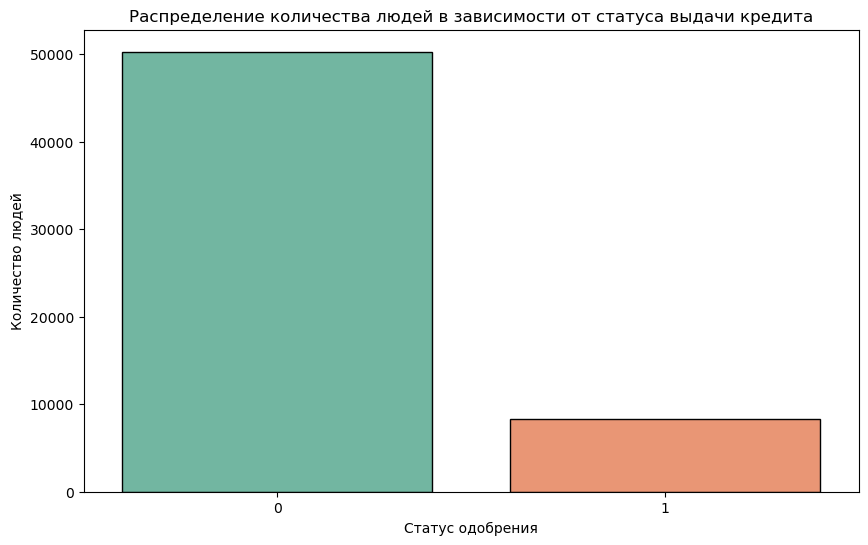

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=df, hue='loan_status', palette='Set2', edgecolor='black', legend=False)
plt.xlabel('Статус одобрения')
plt.ylabel('Количество людей')
plt.title('Распределение количества людей в зависимости от статуса выдачи кредита')
plt.show()

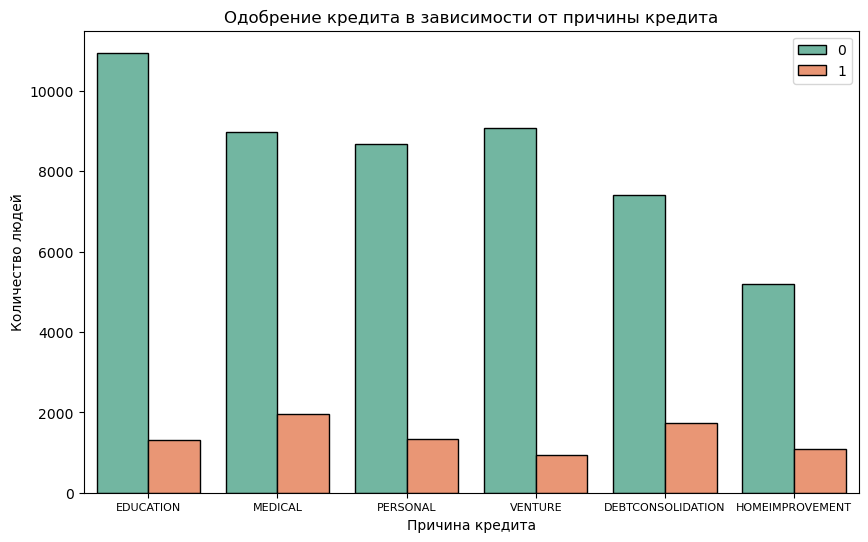

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_intent', data=df, palette='Set2', hue='loan_status', edgecolor='black')
plt.xlabel('Причина кредита')
plt.ylabel('Количество людей')
plt.title('Одобрение кредита в зависимости от причины кредита')
plt.xticks(fontsize=8)
plt.legend(labels=['0', '1'])
plt.show()

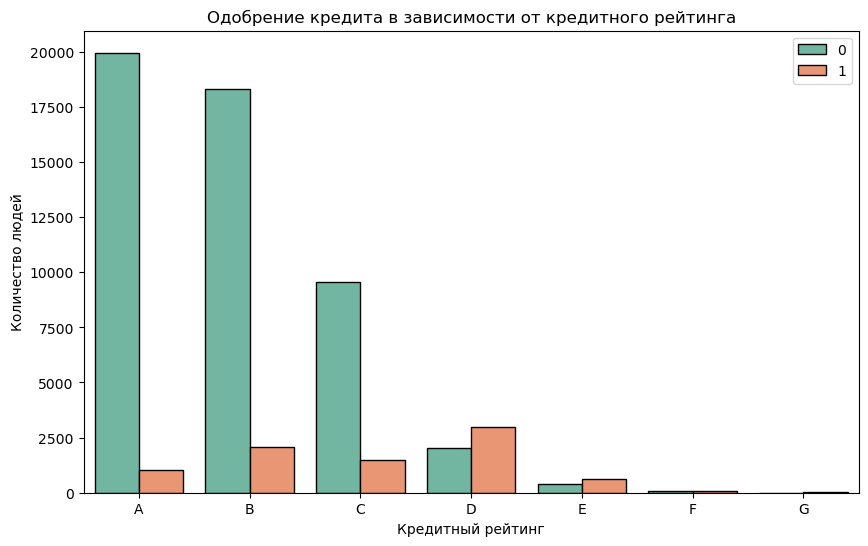

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_grade', data=df, palette='Set2', hue='loan_status', edgecolor='black', order=sorted(df['loan_grade'].unique()))
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество людей')
plt.title('Одобрение кредита в зависимости от кредитного рейтинга')
plt.legend(labels=['0', '1'])
plt.show()

In [20]:
# Для построения графиков отношений между парами признаков сделаем копию данным и закодируем категориальные переменные

df_for_pairplot = df.copy()

le_loan_grade = LabelEncoder()
le_cb_default = LabelEncoder()

df_for_pairplot['loan_grade'] = le_loan_grade.fit_transform(df_for_pairplot['loan_grade'])
df_for_pairplot['cb_person_default_on_file'] = le_cb_default.fit_transform(df_for_pairplot['cb_person_default_on_file'])

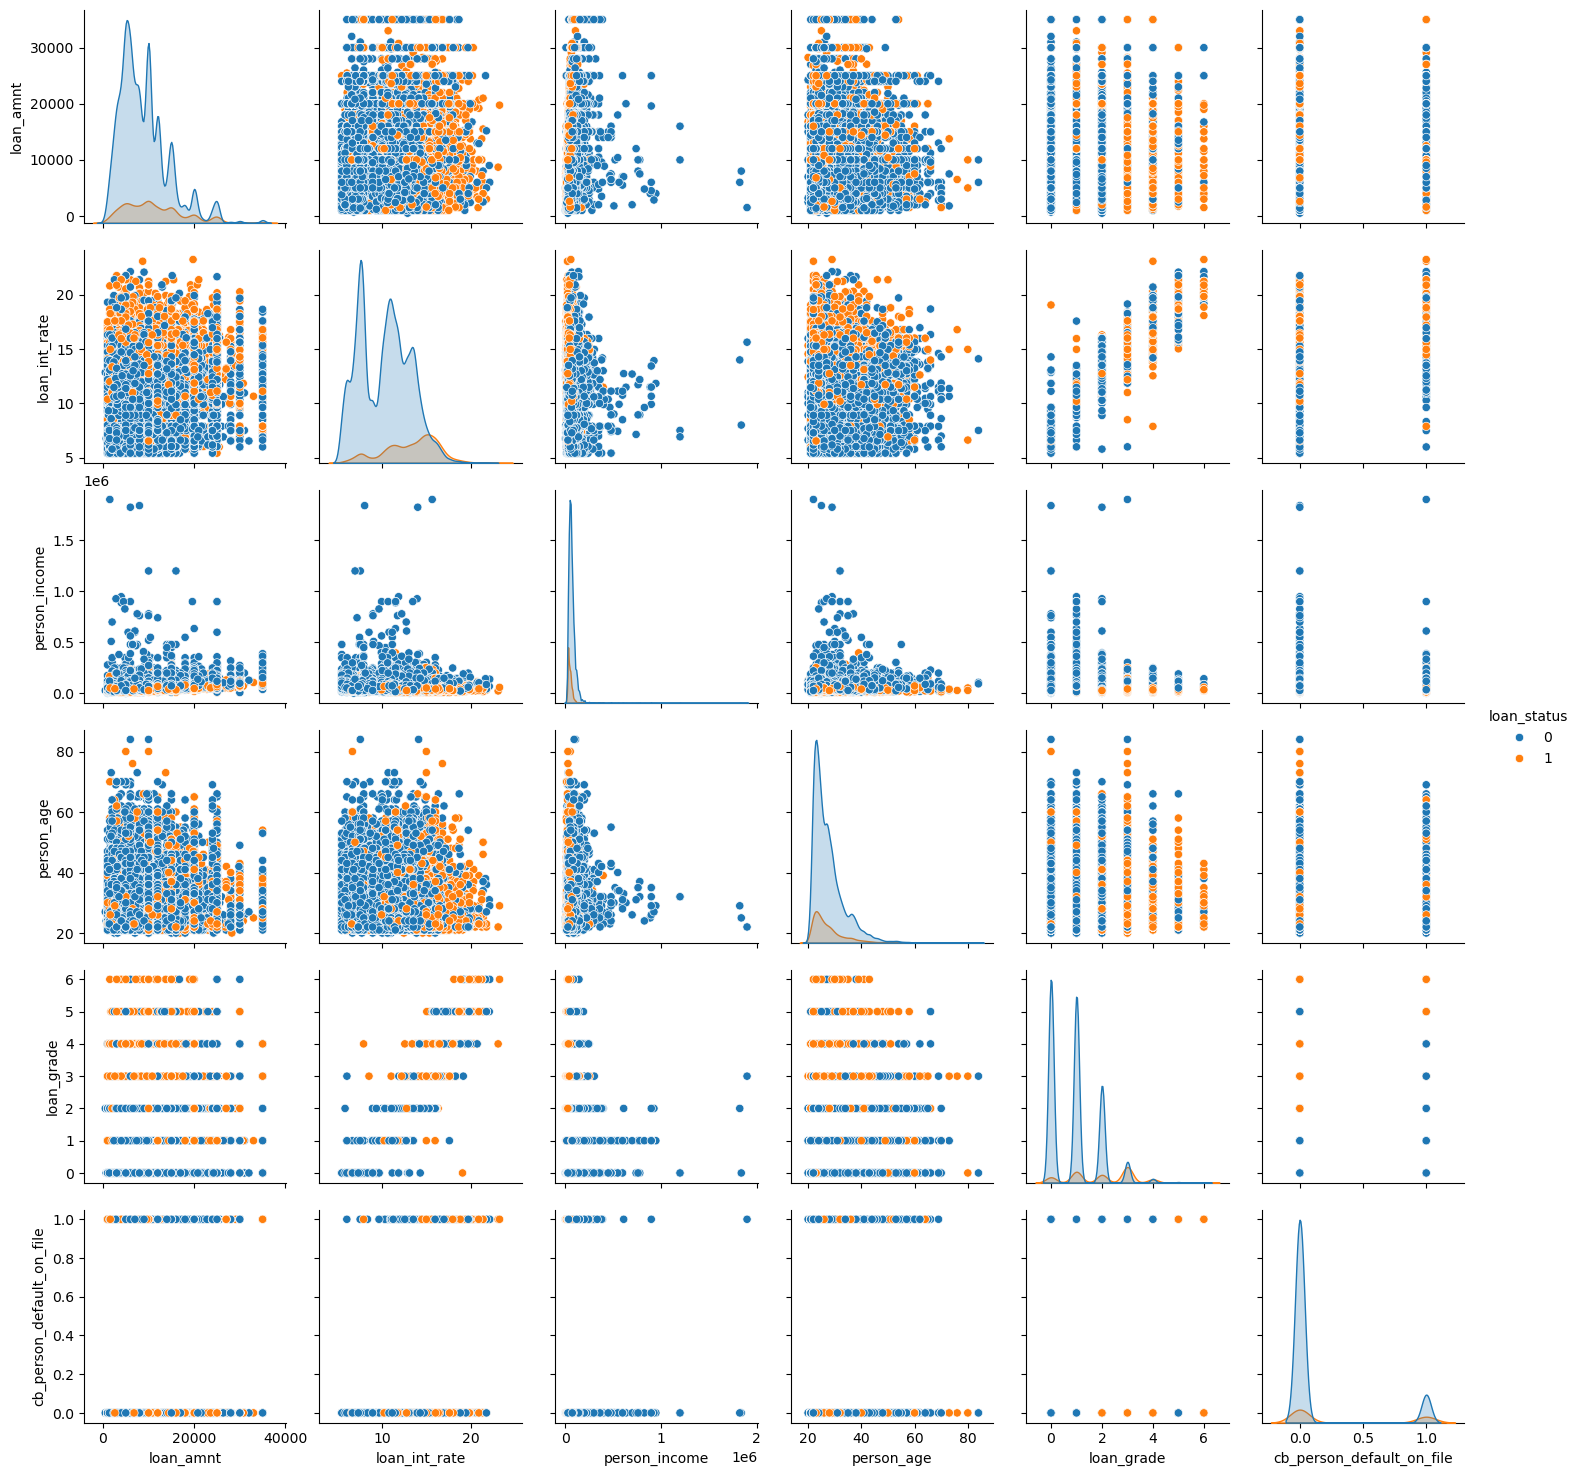

In [23]:
col = ['loan_amnt', 'loan_int_rate', 'person_income', 'person_age', 'loan_status', 'loan_grade', 'cb_person_default_on_file']
sns.pairplot(df_for_pairplot[col], hue='loan_status')
plt.show()

interval columns not set, guessing: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']


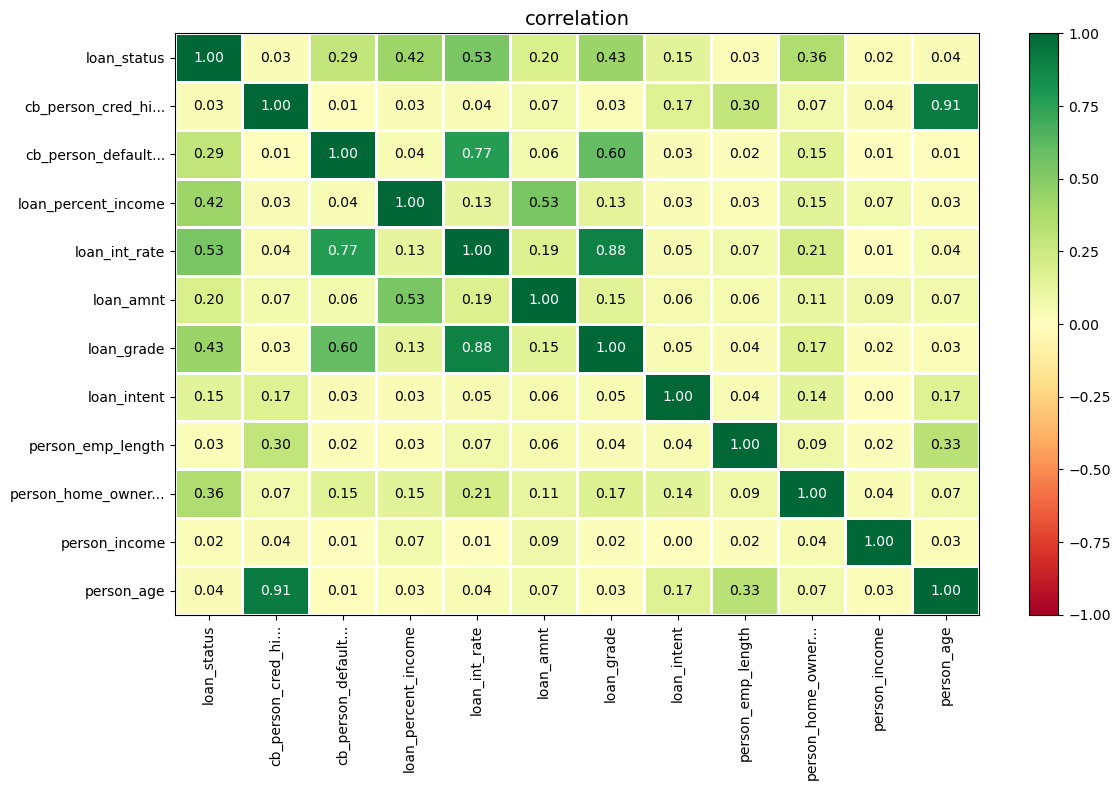

In [25]:
# Построим матрицу корреляции. Иипользуем для этого коэффициент phi_K

phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, figsize=(12, 8))

Можно сделать следующие выводы:

* Хороший кредитный рейтинг связан с более низкими процентными ставками.

* Крупные суммы кредита ведут к более высокому проценту от дохода клиента.

* Возраст, в котором чаще всего берут кредит — от 20-ти до 30-ти лет.

### Предварительная обработка данных

In [10]:
# Сделаем копию данных
df_copy = df.copy()

In [12]:
# Применяем масштабирование, так как некоторые модели чувствительны к масштабу данных. Используем MinMaxScaler.

col_for_scaler = df_copy.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()

df_copy[col_for_scaler] = scaler.fit_transform(df_copy[col_for_scaler])

In [14]:
# Закодируем категориальные переменные

label_encoders = {}

cat_features = df_copy.select_dtypes(include=['object']).columns
for feature in cat_features:
    le = LabelEncoder()
    df_copy[feature] = le.fit_transform(df_copy[feature])
    label_encoders[feature] = le

### Обучение моделей

Обучим сразу несколько моделей, чтобы затем выбрать лучшую

In [16]:
X = df_copy.drop(columns=['loan_status'])
y = df_copy['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Словарь с моделями
models = {
    "Logistic Regression": LogisticRegression(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(verbosity=0),
    "LightGBM": LGBMClassifier(verbosity=0)
}

# Словарь для сохранения обученных моделей
trained_models = {}     

# Проведём кросс-валидацию и сохраним обученные модели
cv = StratifiedKFold(n_splits=5, shuffle=True)
results = []

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    mean_score = scores.mean()
    std_score = scores.std()

    model.fit(X_train, y_train)

    # Сохраняем обученную модель в словарь
    trained_models[model_name] = model

    results.append({
        "Модель": model_name,
        "Среднее AUC": mean_score,
        "Стандартное отклонение AUC": std_score
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Среднее AUC", ascending=False)

print("Результаты кросс-валидации:")
print(results_df)

Результаты кросс-валидации:
                Модель  Среднее AUC  Стандартное отклонение AUC
6             LightGBM     0.955934                    0.002582
4             CatBoost     0.955425                    0.002795
5              XGBoost     0.954084                    0.001487
3    Gradient Boosting     0.939360                    0.003274
2        Random Forest     0.935787                    0.002439
0  Logistic Regression     0.880188                    0.005406
1  k-Nearest Neighbors     0.873741                    0.006084


Видим, что LightGBM, CatBoost и XGBoost имеют лучшие и почти одинаковые результаты. Для прогнозирования можно использовать одну из них.

In [48]:
# Для наглядности построим ROC-кривую

y_proba = trained_models['CatBoost'].predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

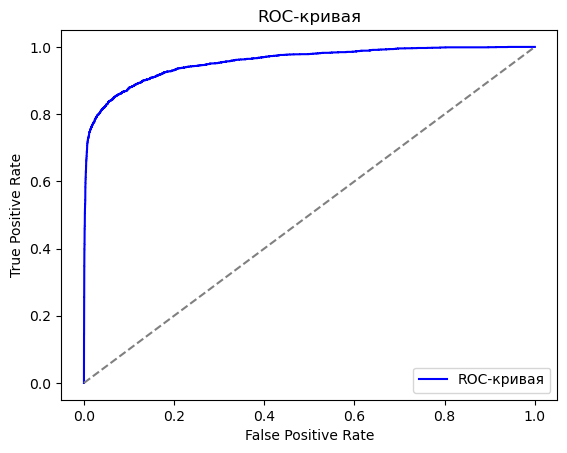

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC-кривая')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()